In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import itertools
from pathlib import Path
import pybedtools
import numpy as np
import seaborn as sns
from biodatatools.utils.common import json_load
from statsmodels.stats.multitest import multipletests
from collections import defaultdict, Counter
from Bio import SeqIO
from mphelper import ProcessWrapPool
import os
import re
from biodata.delimited import DelimitedReader, DelimitedWriter
from scipy.stats import fisher_exact
import subprocess
import sys
from statannotations.Annotator import Annotator
import pyBigWig

In [3]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [4]:
sys.path.append(f"{Path.cwd().parent}")
import utils

In [5]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/databases/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"

# Get Homer motif instances

## Motif types of interest

In [ ]:
# Get the union set of motif types for distal and proximal separately
# Keep TFs with ChIP-seq data available
# Check if these motifs have same motif names after mapping: need to ensure non-redundancy

In [6]:
s = "C1"
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]

In [7]:
inputfile = f"{PROJECT_DIR_o}homer/homer_gene_name_mapping.json"
mapping = json_load(inputfile)
inputfile = f"{PROJECT_DIR_o}homer/homer_motif_name_mapping.json"
mapping2 = json_load(inputfile)
inputfile = f"{PROJECT_DIR_o}homer/homer_motif_groups.json"
groups_temp = json_load(inputfile)

In [8]:
acc_target = json_load(f"{PROJECT_DIR_r}ENCODE/acc_target.json")
acc_target_rev = defaultdict(list)
for acc in acc_target:
	acc_target_rev[acc_target[acc]].append(acc)

In [9]:
# Focus on motifs with ChIP-seq data available

motifs_keep_temp = [motif for motif in mapping if mapping[motif] in acc_target_rev]
len(motifs_keep_temp)

45

In [10]:
# Note that there are HOMER motifs of the same type from different sources (they have extremely similar motif patterns)
# Just need to keep one of them

cs = Counter([mapping2[motif] for motif in motifs_keep_temp])
for motif_name in cs:
	if cs[motif_name] > 1:
		print(motif_name, [motif for motif in motifs_keep_temp if mapping2[motif]==motif_name])

NRF1 ['NRF(NRF)/Promoter/Homer', 'NRF1(NRF)/MCF7-NRF1-ChIP-Seq(Unpublished)/Homer']
RUNX1 ['RUNX(Runt)/HPC7-Runx1-ChIP-Seq(GSE22178)/Homer', 'RUNX1(Runt)/Jurkat-RUNX1-ChIP-Seq(GSE29180)/Homer']


In [11]:
# HPC7: a murine cell line

motifs_keep = [motif for motif in motifs_keep_temp if motif not in ["NRF(NRF)/Promoter/Homer", "RUNX(Runt)/HPC7-Runx1-ChIP-Seq(GSE22178)/Homer"]]
len(motifs_keep)

43

In [12]:
groups = defaultdict(list)
for k in groups_temp:
	for motif in groups_temp[k]:
		if motif in motifs_keep:
			groups[k].append(mapping2[motif])

In [13]:
groups

defaultdict(list,
            {'Other AP-1': ['FOS', 'JUN', 'JUNB', 'FOSL1', 'ATF3'],
             'Other bZIP': ['BACH1', 'NFE2', 'MAFK'],
             'IRF': ['PU.1-IRF', 'IRF2'],
             'ETS': ['GABPA',
              'ELF4',
              'ELF1',
              'ELK1',
              'SPI1',
              'ETS:RUNX',
              'ETS1'],
             'SP/KLF': ['SP2', 'SP1'],
             'STAT/BCL6': ['STAT5A'],
             'CTCF/CTCFL': ['CTCF', 'CTCFL'],
             'GATA/TRPS1': ['GATA1', 'GATA2'],
             'FOX': ['FOXK2'],
             'WT1/EGR': ['EGR1'],
             'E2F': ['E2F4'],
             'JUND/ATF2': ['JUND', 'ATF2'],
             'Other bHLH': ['MITF', 'USF1', 'BHLHE40', 'MYC'],
             'RUNX': ['RUNX1'],
             'MYB': ['MYBL2'],
             'NRF': ['NRF1'],
             'TBP': ['TBP'],
             'YY1': ['YY1'],
             'NFYA': ['NFYA'],
             'GATA:TAL1': ['GATA:TAL1'],
             'ZNF263': ['ZNF263'],
             'TAL1': 

## Homer annotation

In [14]:
motif_files = {}
for p, d in itertools.product(ps, ds):
	outdir = f"{PROJECT_DIR_o}homer/{s}_{p}_{d}/"
	df = pd.read_table(f"{outdir}knownResults.txt")
	for index, row in df.iterrows():
		motif = row["Motif Name"]
		if motif in motifs_keep and motif not in motif_files:
			inputfile = f"{outdir}knownResults/known{index+1}.motif"
			if os.path.exists(inputfile):
				motif_files[mapping2[motif]] = inputfile
len(motif_files)

43

In [32]:
# Combine motif files into one big file

commands = f"cat {' '.join([motif_files[motif] for motif in motif_files])} > {PROJECT_DIR_o}homer/{s}_motifs.motif"
subprocess.run(commands, shell=True)

CompletedProcess(args='cat /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/homer/C1_divergent_distal/knownResults/known1.motif /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/homer/C1_divergent_distal/knownResults/known2.motif /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/homer/C1_divergent_distal/knownResults/known6.motif /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/homer/C1_divergent_distal/knownResults/known8.motif /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/homer/C1_divergent_distal/knownResults/known9.motif /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/homer/C1_divergent_distal/knownResults/known10.motif /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/homer/C1_divergent_distal/knownResults/known13.motif /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/homer/C1_divergent_distal/knownResults/known17.

In [15]:
# Get motif instances
# http://homer.ucsd.edu/homer/ngs/peakMotifs.html

def get_motif_instances(peaks, motif_file, outdir, outputfile):
	commands = ["findMotifsGenome.pl",
				peaks,
				"hg38",
				outdir,
				"-size given",
				f"-find {motif_file}",
				f"> {outputfile}"
			   ]
	subprocess.run(" ".join(commands), shell=True)

In [16]:
# Annotate elements using motifs of interest

pwpool = ProcessWrapPool(len(ps)*len(ds))

motif_file = f"{PROJECT_DIR_o}homer/{s}_motifs.motif"
for p, d in itertools.product(ps, ds):
	peaks = f"{PROJECT_DIR_o}homer/{s}_{p}_{d}.bed"
	outdir = f"{PROJECT_DIR_o}homer/{s}_{p}_{d}/"
	outputfile = f"{outdir}motif_annotation.txt"
	pwpool.run(get_motif_instances, args=[peaks, motif_file, outdir, outputfile])

In [17]:
len(pwpool.finished_tasks)

In [18]:
pwpool.close()

In [19]:
# Check output

df = pd.read_table(f"{outdir}motif_annotation.txt")
df.head(2)

,PositionID,Offset,Sequence,Motif Name,Strand,MotifScore
0,chrX_149504159_149504660,457,AAGATAAGGA,Gata1(Zf)/K562-GATA1-ChIP-Seq(GSE18829)/Homer,+,9.080588
1,chrX_107000009_107000510,431,AAGATAAGAC,Gata1(Zf)/K562-GATA1-ChIP-Seq(GSE18829)/Homer,+,8.630767


In [20]:
inputfile = f"{PROJECT_DIR_r}genomes/human/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"
with open(inputfile, "r") as f:
	fdict = SeqIO.to_dict(SeqIO.parse(f, "fasta"))

In [21]:
# Write the bed file with motif instances

lengths = defaultdict(list)
for p, d in itertools.product(ps, ds):
	outdir = f"{PROJECT_DIR_o}homer/{s}_{p}_{d}/"
	df = pd.read_table(f"{outdir}motif_annotation.txt")
	outputfile = f"{outdir}motif_annotation.bed"
	with DelimitedWriter(outputfile) as dw:
		dw.write(["#chrom", "mstart", "mend", "peak", "motif_name", "gene_name", "strand", "score"])
		for _, row in df.iterrows():
			peak, offset, seq, motif, strand, score = row
			chrom, pstart, pend = peak.split("_")
			if strand == "+":
				mstart = int(pstart) + offset
				mend = mstart + len(seq)
			else:
				mend = int(pstart) + offset + 1
				mstart = mend - len(seq)
			assert fdict[chrom][mstart:mend].seq == seq
			
			# motif names shown on the plot
			motif_name = mapping2[motif]
			# gene names used for mapping to ChIP-seq data
			gene_name = mapping[motif]
			dw.write([chrom, mstart, mend, peak, motif_name, gene_name, strand, score])

# No. non-overlapping instances per element

In [22]:
# Merge overlapping motif instances for a given motif type in a given element

n_instances = {}
for p, d in itertools.product(ps, ds):
	df = pd.read_table(f"{PROJECT_DIR_o}homer/{s}_{p}_{d}/motif_annotation.bed")
	df = df.sort_values(["peak", "motif_name", "mstart"])
	n_instances[(p,d)] = defaultdict(dict)
	
	for (peak, motif), group in df.groupby(["peak", "motif_name"]):
		n_instances[(p,d)][peak][motif] = list()
		current_start = None
		current_end = None
		chrom = group["#chrom"].iloc[0] 
	
		for _, row in group.iterrows():
			if current_start is None:
				current_start = row["mstart"]
				current_end = row["mend"]
			else:
				# check overlap (1bp or more)
				if row["mstart"] <= current_end:
					# extend current interval
					current_end = max(current_end, row["mend"])
				else:
					# no overlap, save current interval
					n_instances[(p,d)][peak][motif].append((chrom, current_start, current_end))
					current_start = row["mstart"]
					current_end = row["mend"]
		n_instances[(p,d)][peak][motif].append((chrom, current_start, current_end))

In [23]:
results = []
for motif in motif_files:
	for p, d in itertools.product(ps, ds):
		for e in n_instances[(p,d)]:
			if motif in n_instances[(p,d)][e]:
				results.append([p.capitalize(), d, e, motif, len(n_instances[(p,d)][e][motif])])
df_n = pd.DataFrame(results, columns=["group", "distance", "e", "motif", "n_instances"])
df_n.head(2)

,group,distance,e,motif,n_instances
0,Divergent,distal,chr10_100289578_100290079,GATA1,1
1,Divergent,distal,chr10_101011389_101011890,GATA1,1


In [24]:
# Show motifs by family; taking all results into account to tell a coherent story

group_order = ["ETS", "CTCF/CTCFL", "Other AP-1"]
group_order.extend([group for group in groups if group not in group_order])
sorted_motifs = [motif for group in group_order for motif in groups[group]]

In [25]:
def feature_boxplots(df, y, ylabel, yticks, outputfile, any_legend=True):
	fig, ax = plt.subplots(2,1,figsize=(13,4))
	
	for d in ds:
		row = ds.index(d)
		hue_plot_params = {
					"data": df[df["distance"]==d],
					"x": "motif",
					"y": y,
				    "palette": ["#313695", "#de77ae"],
					"hue": "group",
					"order": sorted_motifs,
					"fill": False,
					"showfliers": False
				}
		g = sns.boxplot(ax=ax[row], **hue_plot_params)
		pairs = []
		for motif in set(df["motif"]):
			pairs.append([(motif, "Divergent"), (motif, "Unidirectional")])
		annotator = Annotator(g, pairs, **hue_plot_params)
		annotator.configure(test="Mann-Whitney", comparisons_correction="BH", text_offset=2, 
							text_format="star", correction_format="replace", fontsize="small", verbose=False)
		_, results = annotator.apply_and_annotate()

		g.spines[["top","right"]].set_visible(False)
		g.set_title(d.capitalize(), fontsize=bfontsize)
		g.set_ylabel(ylabel, fontsize=bfontsize)
		g.set_yticks(yticks)
		g.set_xlabel("")
		if row == 0:
			g.set_xticklabels([])
		else:
			g.tick_params(axis="x", rotation=30)
			for label in g.get_xticklabels():
				label.set_horizontalalignment("right")
				if label.get_text() in groups["ETS"]:
					label.set_color("#80b1d3")
				elif label.get_text() in groups["CTCF/CTCFL"]:
					label.set_color("#fdb462")

		g.tick_params(labelsize=sfontsize)
		if row == 0 and any_legend:
			g.legend(fontsize=sfontsize, frameon=False)
		else:
			g.legend([],[],frameon=False)
	
	plt.subplots_adjust(hspace=0.5)
	plt.savefig(outputfile, bbox_inches="tight", transparent=True)

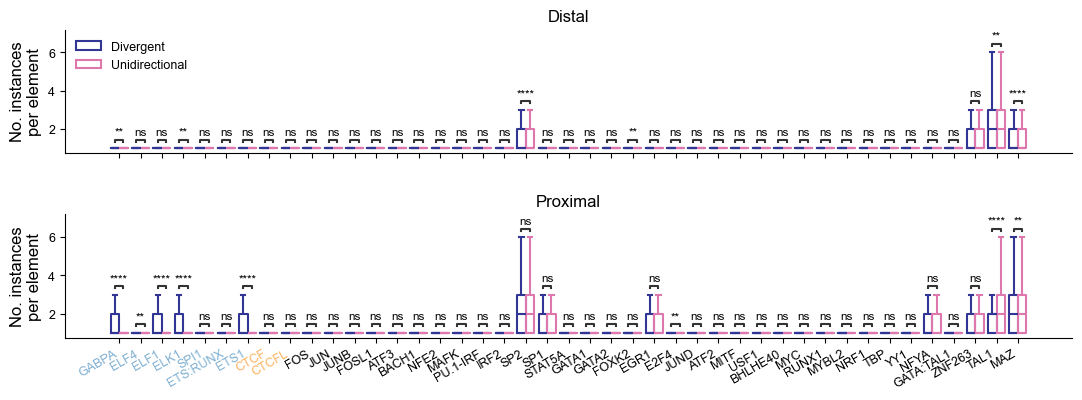

In [26]:
outputfile = f"{PROJECT_DIR_o}figures/SuppFig4a.pdf"
feature_boxplots(df_n, "n_instances", "No. instances\nper element", [2,4,6], outputfile)

# Motif score

In [27]:
# Keep the best match for a given motif type in a given element
# Motif Score (log odds score of the motif matrix, higher scores are better matches)
# http://homer.ucsd.edu/homer/motif/creatingCustomMotifs.html#:~:text=score%20=%20log(pG1/,thresholds%20are%20around%205.0%2D10.0

for p, d in itertools.product(ps, ds):
	inputfile = f"{PROJECT_DIR_o}homer/{s}_{p}_{d}/motif_annotation.bed"
	outputfile = f"{PROJECT_DIR_o}homer/{s}_{p}_{d}/motif_annotation_best_match.bed"
	df = pd.read_table(inputfile)
	idx = df.groupby(["peak", "motif_name"])["score"].idxmax()
	grouped = df.loc[idx].reset_index(drop=True)
	grouped.to_csv(outputfile, sep="\t", index=False)
	pybedtools.BedTool(outputfile).sort().saveas(outputfile)

In [28]:
results = []
for p, d in itertools.product(ps, ds):
	inputfile = f"{PROJECT_DIR_o}homer/{s}_{p}_{d}/motif_annotation_best_match.bed"
	df = pd.read_table(inputfile)
	for _, row in df.iterrows():
		chrom, mstart, mend, peak, motif_name, gene_name, strand, score = row
		results.append([d, p.capitalize(), motif_name, peak, "_".join([chrom, str(mstart), str(mend)]), strand, score])
df_score = pd.DataFrame(results, columns=["distance", "group", "motif", "peak", "motif_position", "strand", "score"])
df_score.head(2)

,distance,group,motif,peak,motif_position,strand,score
0,distal,Divergent,TAL1,chr1_1021037_1021538,chr1_1021181_1021189,+,6.307963
1,distal,Divergent,EGR1,chr1_1021037_1021538,chr1_1021191_1021201,-,7.869428


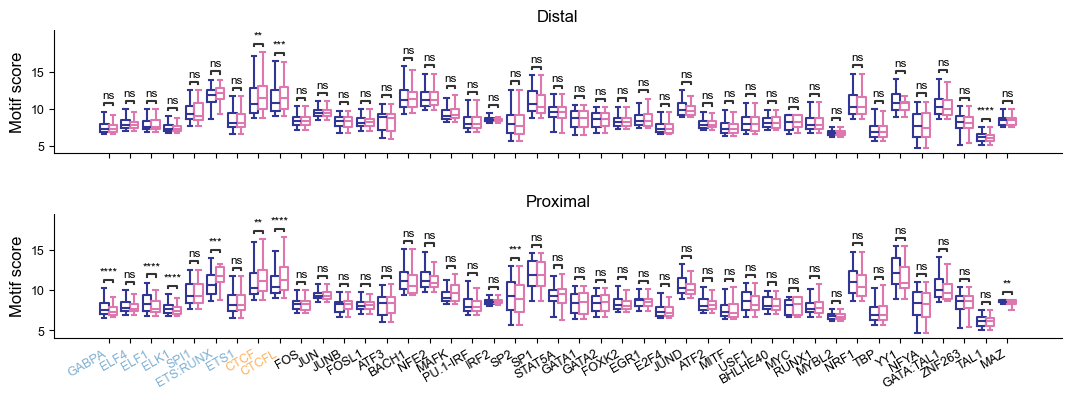

In [29]:
outputfile = f"{PROJECT_DIR_o}figures/SuppFig4b.pdf"
feature_boxplots(df_score, "score", "Motif score", [5,10,15], outputfile, False)

# PhyloP

## Fixed window

In [30]:
# Get pwm

pwms = defaultdict(list)
for motif in motif_files:
	with DelimitedReader(motif_files[motif]) as dr:
		for cols in dr:
			if ">" not in cols[0]:
				pwms[motif].append(cols)
	pwms[motif] = np.array(pwms[motif], dtype=float)

In [31]:
np.max([pwms[motif].shape[0] for motif in pwms])

20

In [32]:
bw = pyBigWig.open(f"{PROJECT_DIR_d}UCSC/phyloP/hg38/hg38.phyloP100way.bw")
df_features = {}
for p, d in itertools.product(ps, ds):
	b = pybedtools.BedTool(f"{PROJECT_DIR_o}homer/{s}_{p}_{d}/motif_annotation_best_match.bed")
	for motif in motifs_keep:
		motif_name = mapping2[motif]
		b_keep = b.filter(lambda x: x[4] == motif_name)
		results = []
		index = []
		for i in b_keep:
			chrom, start, end = i.fields[:3]
			strand = i.fields[-2]
			if pwms[motif_name].shape[0] % 2 == 0:
				center = (int(start)+int(end)-1)//2 if strand == "+" else (int(start)+int(end))//2
			else:
				center = (int(start)+int(end)-1)//2
			
			scores = bw.values(chrom, center-15, center+16)
			if strand == "-":
				scores = scores[::-1]
			results.append(scores)
			index.append("_".join(i.fields[:3]))
		df_features[(p,d,motif_name)] = pd.DataFrame(results, index=index)

In [33]:
df_reformat = {}
for k in df_features:
	df = df_features[k].reset_index()
	df_reformat[k] = pd.melt(df,
						  id_vars="index",
						  value_vars=list(df.columns[1:]),
						  var_name="Position",
						  value_name="Feature"
						  )

In [34]:
df_metaplots = {}
for d in ds:
	for motif in motifs_keep:
		motif_name = mapping2[motif]
		dfs = []
		for p in ps:
			df = df_reformat[(p,d,motif_name)].copy()
			df["Label"] = p.capitalize()
			dfs.append(df)
		df_metaplots[(d, motif_name)] = pd.concat(dfs).reset_index(drop=True)	

In [35]:
def individual_metaplot(df, d, motif, ax, ylabel=True, xlabel=True, legend=True):
	utils.generate_feature_metaplot(df[(d, motif)], ["#313695","#de77ae"], ["Divergent","Unidirectional"], ax, False, "se")
	if motif in groups["ETS"]:
		color = "#80b1d3"
	elif motif in groups["CTCF/CTCFL"]:
		color = "#fdb462"
	elif motif in groups["Other AP-1"]:
		color = "#bc80bd"
	else:
		color = "#000000"
	ax.set_title(motif, fontsize=bfontsize, c=color)
	# ax.set_xticks([0,15,30])
	if xlabel:
		ax.set_xlabel("Distance (bp)", fontsize=bfontsize)
		# ax.set_xticklabels([-15,0,15])
	else:
		ax.set_xlabel("")
		ax.set_xticklabels([])
	
	if ylabel:
		ax.set_ylabel("phyloP", fontsize=bfontsize)
		ax.yaxis.set_label_coords(-0.6, 0.5)
	else:
		ax.set_ylabel("")
	if legend:
		ax.legend(loc="upper left", bbox_to_anchor=(1.1,1), fontsize=sfontsize, frameon=False)
	else:
		ax.legend([],[],frameon=False)
	ax.axhline(y=0, ls="--", c="#bdbdbd")

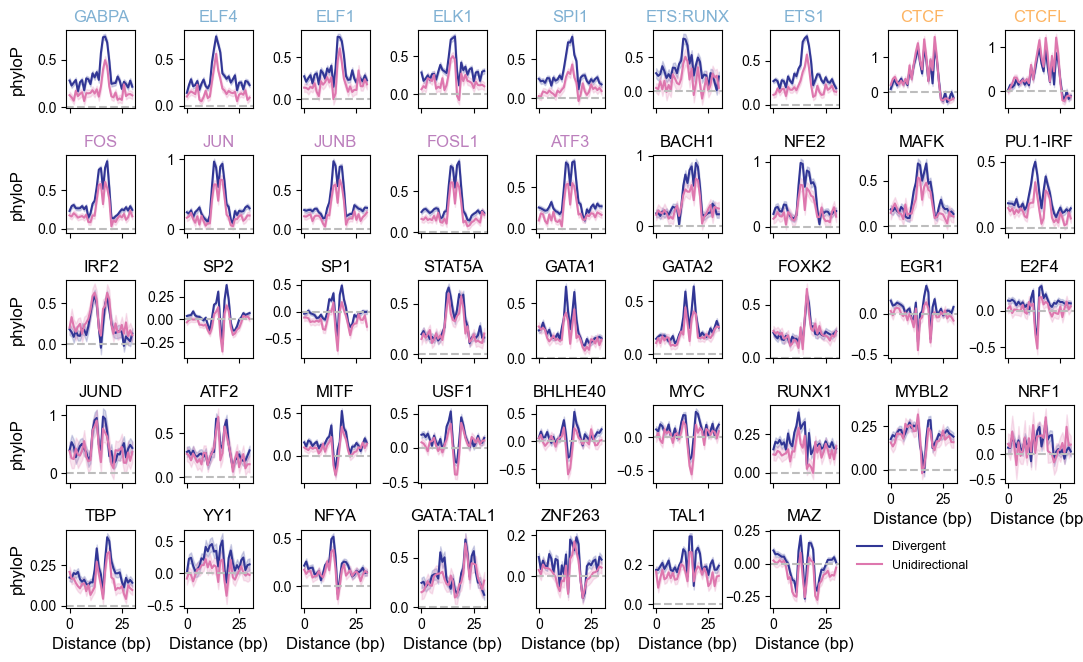

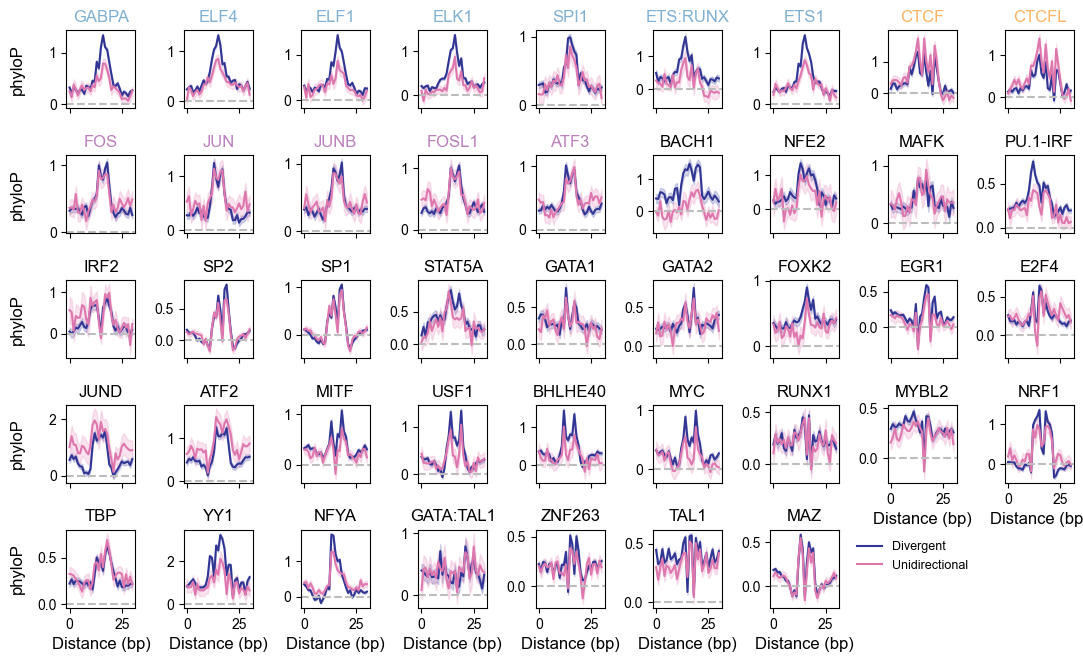

In [36]:
for d in ds:
	nrow = 5
	ncol = 9
	fig, ax = plt.subplots(nrow,ncol,figsize=(13,7.5))
	for col in [ncol-2,ncol-1]:
		ax[nrow-1,col].axis("off")
	for motif in sorted_motifs:
		row = sorted_motifs.index(motif) // ncol
		col = sorted_motifs.index(motif) % ncol
		ylabel = True if col == 0 else False
		if row == nrow-1 or (row == nrow-2 and col in [ncol-2, ncol-1]):
			xlabel = True 
		else:
			xlabel = False
		if col == ncol-3 and row == nrow-1:
			legend = True
		else:
			legend = False

		g = individual_metaplot(df_metaplots, d, motif, ax[row, col], ylabel, xlabel, legend)	
	plt.subplots_adjust(wspace=0.7, hspace=0.6) 
	outputfile = f"{PROJECT_DIR_o}figures/SuppFig5.pdf" if d == "distal" else f"{PROJECT_DIR_o}figures/SuppFig6.pdf"
	plt.savefig(outputfile, bbox_inches="tight", transparent=True)

## Motif length

In [37]:
# Highlight three motifs in ExtDataFig
# Show metaplots along with the motif pattern

motifs_highlight = ["GABPA", "FOS", "CTCFL"]

In [38]:
# Get phyloP scores


d = "distal"
df_features2 = {}
for p, motif in itertools.product(ps, motifs_highlight):
	b = pybedtools.BedTool(f"{PROJECT_DIR_o}homer/{s}_{p}_{d}/motif_annotation_best_match.bed")
	b_keep = b.filter(lambda x: x[4] == motif)
	results = []
	index = []
	for i in b_keep:
		chrom, start, end = i.fields[:3]
		strand = i.fields[-2]
		scores = bw.values(chrom, int(start), int(end))
		if strand == "-":
			scores = scores[::-1]
		results.append(scores)
		index.append("_".join(i.fields[:3]))
	df_features2[(p,d,motif)] = pd.DataFrame(results, index=index)

In [39]:
df_reformat2 = {}
for k in df_features2:
	df = df_features2[k].reset_index()
	df_reformat2[k] = pd.melt(df,
							  id_vars="index",
							  value_vars=list(df.columns[1:]),
							  var_name="Position",
							  value_name="Feature"
							  )

In [40]:
df_metaplots2 = {}
for motif in motifs_highlight:
	dfs = []
	for p in ps:
		df = df_reformat2[(p,d,motif)].copy()
		df["Label"] = p.capitalize()
		dfs.append(df)
	df_metaplots2[(d, motif)] = pd.concat(dfs).reset_index(drop=True)	

Matplotlib is building the font cache; this may take a moment.


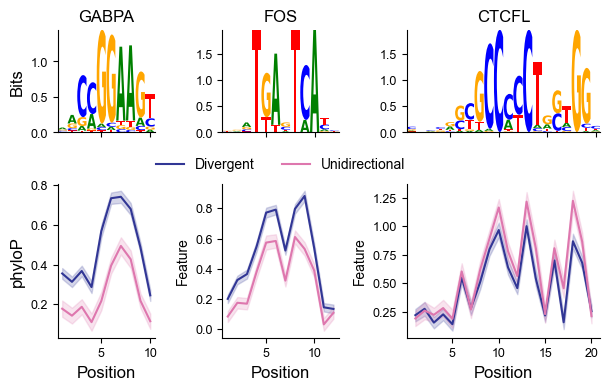

In [41]:
fig, ax = plt.subplots(2,3,figsize=(7,4),height_ratios=[2,3],width_ratios=[pwms[motif].shape[0] for motif in motifs_highlight])

for motif in motifs_highlight:
	col = motifs_highlight.index(motif)
	for row in [0,1]:		
		if row == 0:
			# Sequence logo
			n = list(pwms).index(motif)
			pwm_ic = pwms[motif] * utils.compute_per_position_ic(pwms[motif])[:, None]
			utils.plot_motif_on_ax(pwm_ic, ax[0,col], motif, True)

			xticks = [4,9] if col != 2 else [4,9,14,19]
			ax[row,col].set_xticks(xticks)
			ax[row,col].set_xticklabels([])
			if col == 0:
				ax[row,col].set_ylabel("Bits", fontsize=bfontsize)

		else:
			# Metaplot
			utils.generate_feature_metaplot(df_metaplots2[(d, motif)], ["#313695","#de77ae"], ["Divergent","Unidirectional"], ax[row,col], False, "se")
			ax[row,col].set_xlabel("Position", fontsize=bfontsize)
			xticks2 = [xtick for xtick in xticks]
			xticklabels = [xtick+1 for xtick in xticks]
			ax[row,col].set_xticks(xticks)
			ax[row,col].set_xticklabels(xticklabels)
			if col == 0:
				ax[row,col].set_ylabel("phyloP", fontsize=bfontsize)
			if col == 1:
				ax[row,col].legend(loc="upper center", bbox_to_anchor=(0.5,1.25), ncols=2, frameon=False)
			else:
				ax[row,col].legend([], [], frameon=False)

		ax[row,col].spines[["top", "right"]].set_visible(False)
		ax[row,col].tick_params(labelsize=sfontsize)
	
plt.subplots_adjust(wspace=0.5, hspace=0.4)
outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig4b.pdf"
plt.savefig(outputfile, bbox_inches="tight", transparent=True)

# ChIP-seq validated motif enrichment 

In [42]:
# Keep motif instances overlapping with ENCODE ChIP-seq data for the corresponding TF (any dataset if multiple).

for p, d in itertools.product(ps, ds):
	b1 = pybedtools.BedTool(f"{PROJECT_DIR_o}homer/{s}_{p}_{d}/motif_annotation_best_match.bed")
	outputfile = f"{PROJECT_DIR_o}homer/{s}_{p}_{d}/motif_annotation_best_match_ChIP.bed"
	keep = set()
	with DelimitedWriter(outputfile) as dw:
		for motif in motifs_keep:
			gene_name = mapping[motif]
			motif_name = mapping2[motif]
			for acc in acc_target_rev[gene_name]:
				b2 = pybedtools.BedTool(f"{PROJECT_DIR_r}ENCODE/{acc}.bed.gz")
				overlap = b1.intersect(b2, wao=True)
				for i in overlap:
					if int(i.fields[-1]) > 0 and i.fields[4] == motif_name:
						if tuple(i.fields) not in keep:
							dw.write(i.fields[:8])
							keep.add(tuple(i.fields[:8]))

In [43]:
results = []
for p, d in itertools.product(ps, ds):
	b1 = pybedtools.BedTool(f"{PROJECT_DIR_o}homer/{s}_{p}_{d}.bed")
	b2 = pybedtools.BedTool(f"{PROJECT_DIR_o}homer/{s}_{p}_{d}/motif_annotation_best_match_ChIP.bed")
	tot = len(b1)
	for motif in set([i.fields[4] for i in b2]):
		# No. elements with a given motif type
		n = len(set([i.fields[3] for i in b2 if i.fields[4]==motif]))
		results.append([d, p.capitalize(), motif, n, n/tot])
df_chip = pd.DataFrame(results, columns=["distance", "group", "motif", "Homer+ChIP-seq", "fraction"])
df_chip.head(2)

,distance,group,motif,Homer+ChIP-seq,fraction
0,distal,Divergent,GATA:TAL1,552,0.065589
1,distal,Divergent,FOXK2,664,0.078897


In [44]:
# Sort motifs based on fraction of divergent elements

motif_orders = {}
for d in ds:
	df = df_chip[df_chip["distance"]==d]
	motif_orders[d] = list(df[df["group"]=="Divergent"].sort_values(by="fraction", ascending=False)["motif"])

In [45]:
# Fisher exact test: divergent vs. unidirectional

pvalues = {}
for d in ds:
	tot1 = len(pybedtools.BedTool(f"{PROJECT_DIR_o}homer/{s}_{ps[0]}_{d}.bed"))
	tot2 = len(pybedtools.BedTool(f"{PROJECT_DIR_o}homer/{s}_{ps[1]}_{d}.bed"))
	for motif in motif_orders[d]:
		df = df_chip[(df_chip["distance"]==d) & (df_chip["motif"]==motif)]
		# divergent: with motif
		n1 = int(df.loc[df["group"]=="Divergent", "Homer+ChIP-seq"].iloc[0])
		# divergent: without motif
		n2 = tot1 - n1
		# unidirectional: with motif
		n3 = int(df.loc[df["group"]=="Unidirectional", "Homer+ChIP-seq"].iloc[0])
		# unidirectional: without motif
		n4 = tot2 - n3
		_, pvalues[(d,motif)] = fisher_exact([[n1,n2],[n3,n4]])

In [46]:
# FDR correction

flat_pvals = [pvalues[k] for k in pvalues]
_, pvals_corrected, _, _ = multipletests(flat_pvals, method='fdr_bh')

FDRs = {}
for i, k in enumerate(list(pvalues)):
	FDRs[k] = pvals_corrected[i]

In [47]:
# Color code

colors = {}
for d, motif_name in FDRs:
	df = df_chip[df_chip["motif"]==motif_name]
	tot1 = len(pybedtools.BedTool(f"{PROJECT_DIR_o}homer/{s}_{ps[0]}_{d}.bed"))
	tot2 = len(pybedtools.BedTool(f"{PROJECT_DIR_o}homer/{s}_{ps[1]}_{d}.bed"))
	n1 = int(df.loc[(df["distance"]==d) & (df["group"]=="Divergent"), "Homer+ChIP-seq"].iloc[0])
	n2 = int(df.loc[(df["distance"]==d) & (df["group"]=="Unidirectional"), "Homer+ChIP-seq"].iloc[0])
	if FDRs[(d,motif_name)] < 0.05 and np.max([n1/tot1,n2/tot2]) > 0.05:
		colors[(d,motif_name)] = "#313695" if n1/tot1 > n2/tot2 else "#de77ae"
	else:
		colors[(d,motif_name)] = "#969696"

In [ ]:
for d in ds:
	figsize = (8.5,3) if d == "distal" else (12,3.5)
	fig, ax = plt.subplots(figsize=figsize)
	df = df_chip[(df_chip["distance"]==d)]
	g = sns.barplot(data=df, x="motif", y="fraction", order=motif_orders[d], 
					hue="group", palette=["#313695", "#de77ae"], ax=ax)
	g.spines[["top", "right"]].set_visible(False)
	g.set_ylabel("Fraction of elements with motifs", fontsize=bfontsize)
	g.set_xlabel("")
	for label in g.get_xticklabels():
		label.set_color(colors[(d,label.get_text())])
	# labelsize = sfontsize if d == "distal" else bfontsize
	g.tick_params(axis="x", labelsize=bfontsize, rotation=90)
	g.legend(frameon=False)
	yticks = [0,0.1,0.2] if d == "distal" else [0,0.2,0.4]
	g.set_yticks(yticks)

	if d == "distal":
		outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig4c.pdf"
	else:
		outputfile = f"{PROJECT_DIR_o}figures/SuppFig3b.pdf"
	plt.savefig(outputfile, bbox_inches="tight", transparent=True)